In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [79]:
train = pd.read_excel('D:/Downloads/Restaurant_food_cost/Data_Train.xlsx')
test = pd.read_excel('D:/Downloads/Restaurant_food_cost/Data_Test.xlsx')

In [80]:
train.shape, test.shape

((12690, 9), (4231, 8))

### Data exploration

In [81]:
# check for duplicate records... didn't remove the duplicate records as it was bringing score down
train.duplicated().sum(), test.duplicated().sum()
#train.drop_duplicates(keep='first', inplace=True)
#train.reset_index(inplace=True)
#test.drop_duplicates(keep='first', inplace=True)
#test.reset_index(inplace=True)

(25, 1)

In [82]:
train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [83]:
train.info()
#train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
TITLE            12690 non-null object
RESTAURANT_ID    12690 non-null int64
CUISINES         12690 non-null object
TIME             12690 non-null object
CITY             12578 non-null object
LOCALITY         12592 non-null object
RATING           12688 non-null object
VOTES            11486 non-null object
COST             12690 non-null int64
dtypes: int64(2), object(7)
memory usage: 892.3+ KB


In [84]:
for i in train.columns:
    print("Unique values in", i, train[i].nunique())

Unique values in TITLE 113
Unique values in RESTAURANT_ID 11892
Unique values in CUISINES 4155
Unique values in TIME 2689
Unique values in CITY 359
Unique values in LOCALITY 1416
Unique values in RATING 32
Unique values in VOTES 1847
Unique values in COST 86


### Data pre-processing

In [85]:
# merge train and test
df = train.append(test,ignore_index=True)

In [86]:
df = df[['TITLE', 'CUISINES', 'TIME', 'CITY', 'LOCALITY', 'RATING', 'VOTES', 'COST']]

In [87]:
def extract_closed(time):
    a = re.findall('Closed \(.*?\)', time)
    if a != []:
        return a[0]
    else:
        return 'NA'

df['CLOSED'] = df['TIME'].apply(extract_closed)

In [88]:
df['TIME'] = df['TIME'].str.replace(r'Closed \(.*?\)','')
#df['TIME'] = df['TIME'].str.replace(r'Closed...','')

In [89]:
df['RATING'] = df['RATING'].str.replace('NEW', '1')
df['RATING'] = df['RATING'].str.replace('-', '1').astype(float)

In [90]:
df['VOTES'] = df['VOTES'].str.replace(' votes', '').astype(float)

In [91]:
df['CITY'].fillna('Missing', inplace=True)  
df['LOCALITY'].fillna('Missing', inplace=True)  
df['RATING'].fillna(3.8, inplace=True)  
df['VOTES'].fillna(0.0, inplace=True) 

In [92]:
df['COST'] = df['COST'].astype(float)

In [93]:
df.head(2)

,TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,CLOSED
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA


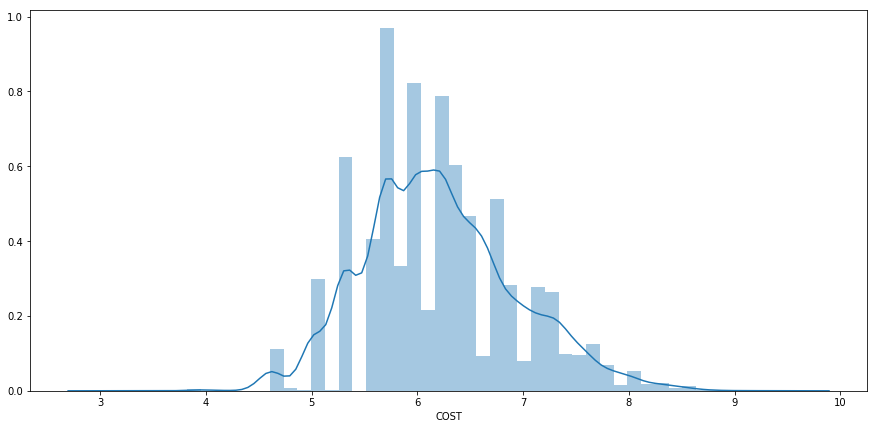

In [120]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(train_df['COST'].sort_values(), ax=ax)
plt.show()

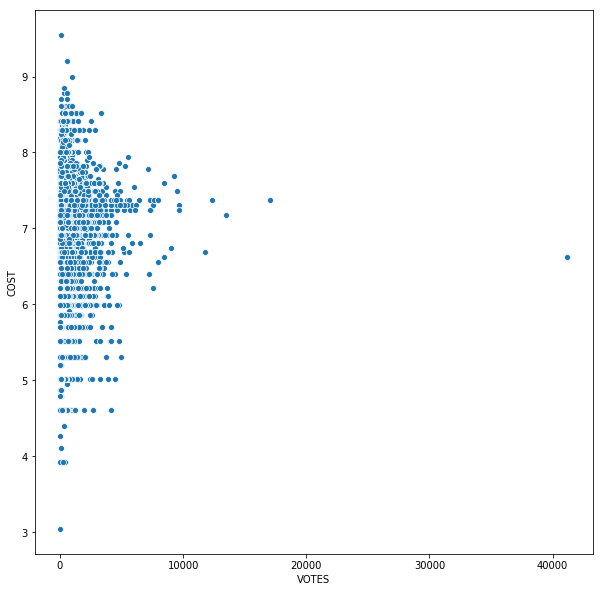

In [125]:
plt.figure(figsize=(10,10))
sns.scatterplot(y='COST',x='VOTES',data=train_df)
plt.show()

In [94]:
df['TITLE'].nunique(), df['CUISINES'].nunique()

(123, 5183)

In [95]:
calc_mean = df.groupby(['CITY'], axis=0).agg({'RATING': 'mean'}).reset_index()
calc_mean.columns = ['CITY','CITY_MEAN_RATING']
df = df.merge(calc_mean, on=['CITY'],how='left')

calc_mean = df.groupby(['LOCALITY'], axis=0).agg({'RATING': 'mean'}).reset_index()
calc_mean.columns = ['LOCALITY','LOCALITY_MEAN_RATING']
df = df.merge(calc_mean, on=['LOCALITY'],how='left')

In [96]:
df.head(2)

,TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,CLOSED,CITY_MEAN_RATING,LOCALITY_MEAN_RATING
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA,3.376271,3.388889
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA,3.584588,3.472222


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf1 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_title = tf1.fit_transform(df['TITLE'])
df_title = pd.DataFrame(data=df_title.toarray(), columns=tf1.get_feature_names())

tf2 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_cuisines = tf2.fit_transform(df['CUISINES'])
df_cuisines = pd.DataFrame(data=df_cuisines.toarray(), columns=tf2.get_feature_names())

tf3 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_city = tf3.fit_transform(df['CITY'])
df_city = pd.DataFrame(data=df_city.toarray(), columns=tf3.get_feature_names())

tf4 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_locality = tf4.fit_transform(df['LOCALITY'])
df_locality = pd.DataFrame(data=df_locality.toarray(), columns=tf4.get_feature_names())

tf5 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
df_time = tf5.fit_transform(df['TIME'])
df_time = pd.DataFrame(data=df_time.toarray(), columns=tf5.get_feature_names())

In [98]:
df.head(2)

,TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,CLOSED,CITY_MEAN_RATING,LOCALITY_MEAN_RATING
0,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200.0,NA,3.376271,3.388889
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500.0,NA,3.584588,3.472222


In [99]:
df = pd.concat([df, df_title, df_cuisines, df_city, df_locality, df_time], axis=1) 
df.drop(['TITLE', 'CUISINES', 'CITY', 'LOCALITY', 'TIME'], axis=1, inplace=True)

In [100]:
df = pd.get_dummies(df, columns=['CLOSED'], drop_first=True)

In [101]:
df.shape

(16921, 2285)

In [102]:
train_df = df[df['COST'].isnull()!=True]
test_df = df[df['COST'].isnull()==True]
test_df.drop('COST', axis=1, inplace=True)

In [103]:
train_df.shape, test_df.shape

((12690, 2285), (4231, 2284))

In [104]:
train_df['COST'] = np.log1p(train_df['COST'])

In [105]:
#Train - test split

X = train_df.drop(labels=['COST'], axis=1)
y = train_df['COST'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [106]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((9517, 2284), (9517,), (3173, 2284), (3173,))

### Build the model

In [107]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [109]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.9, max_features=1.0, bootstrap=True, 
                      bootstrap_features=True, oob_score=True, warm_start=False, n_jobs=1, random_state=42, verbose=1)
br.fit(X_train, y_train)
y_pred_br = br.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.exp(y_cv), np.exp(y_pred_br))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE: 0.3578688814145328


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


In [110]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=40, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                           random_state=42, verbose=1, warm_start=False)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.exp(y_cv), np.exp(y_pred_rf))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   46.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE: 0.361615008278514


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


### Predict on test set

In [111]:
#Xtrain = train_df.drop(labels='COST', axis=1)
#ytrain = train_df['COST'].values
Xtest = test_df

In [112]:
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor

err_br = []
y_pred_totbr = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    br = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=1.0, max_features=1.0, bootstrap=True,
                          bootstrap_features=True, oob_score=False, warm_start=False, n_jobs=1, random_state=42, verbose=0)
    
    br.fit(X_train, y_train)
    y_pred_br = br.predict(X_test)

    print("RMSE BR:", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_br))))

    err_br.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_br))))
    p = br.predict(Xtest)
    y_pred_totbr.append(p)

RMSE BR: 0.3586403283980863
RMSE BR: 0.3612735606984031
RMSE BR: 0.3512101629840391
RMSE BR: 0.3534293372605212
RMSE BR: 0.33879583029544424
RMSE BR: 0.3340686854816292
RMSE BR: 0.36207982389083887
RMSE BR: 0.37966539399916555
RMSE BR: 0.35570315165822536
RMSE BR: 0.3399877308088601
RMSE BR: 0.34484098385232476
RMSE BR: 0.3590649635990978
RMSE BR: 0.34023916205772353
RMSE BR: 0.3584511942532491
RMSE BR: 0.3703423543386018


In [113]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

err_rf = []
y_pred_totrf = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf = RandomForestRegressor(n_estimators=40, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                           random_state=42, verbose=0, warm_start=False)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("RMSE RF: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_rf))))

    err_rf.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_rf))))
    p = rf.predict(Xtest)
    y_pred_totrf.append(p)

RMSE RF:  0.3661418609828676
RMSE RF:  0.36823336386822775
RMSE RF:  0.3517450121344564
RMSE RF:  0.35393052211099113
RMSE RF:  0.3442830871038174
RMSE RF:  0.3387679697346366
RMSE RF:  0.37353777467157284
RMSE RF:  0.38019489944323615
RMSE RF:  0.3655217869700705
RMSE RF:  0.3504209419667851
RMSE RF:  0.35519375002088177
RMSE RF:  0.36271235847953415
RMSE RF:  0.3481361162391413
RMSE RF:  0.36713336281840697
RMSE RF:  0.3741193686715015


In [114]:
np.mean(err_br,0), np.mean(err_rf,0)

(0.3538528442384139, 0.3600048116810752)

In [116]:
br_final = np.exp(np.mean(y_pred_totbr,0))
rf_final = np.exp(np.mean(y_pred_totrf,0))

In [117]:
y_pred = (br_final*0.5 + rf_final*0.5) 
y_pred

array([1099.3434993 ,  410.5858813 ,  639.98872324, ...,  403.47326182,
        251.32095733,  364.10048935])

In [130]:
pd.DataFrame(y_pred, columns = ['COST']).to_excel("D:/Downloads/Restaurant_food_cost/Submission.xlsx", index = False)